This notebook performs downstream Drug Response Prediction with the augmented cell line data and patient datasets. Uses a neural network to perform DRP.

Majority voting is used to get the pseudo labels.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from scipy.stats import mode

In [4]:
import sys
sys.path.append("../src/tab_ddpm/")

In [5]:
device = torch.device("cuda:0")

In [6]:
torch.manual_seed(0)

In [7]:
sample_id = 1

#### Load Datasets

In [8]:
tcga_train_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_train_sample{sample_id}.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [9]:
tcga_test_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_test_sample{sample_id}.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [10]:
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_joint_UDA.csv", index_col=0) # only UDA + LDM
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned.csv", index_col=0) # no UDA, only conditioning
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda.csv", index_col=0) # all possible losses
augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda_v2.csv", index_col=0) # without KLD, MSE mean in training. Only uses Gaussian loss from TDDPM and coral loss
print(augmented_cl_df.shape)
augmented_cl_df

(1744, 7776)


,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
ACH-000816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-002338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Load response files

In [11]:
cl_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/yiming_data_folder/dataset/CellLine/patient_auc.csv")
cl_responses_df

,depmap_id,drug_name,auc
0,ACH-000001,JW-7-24-1,0.778432
1,ACH-000002,JW-7-24-1,0.788327
2,ACH-000004,JW-7-24-1,0.737630
3,ACH-000006,JW-7-24-1,0.176396
4,ACH-000007,JW-7-24-1,0.569751
...,...,...,...
226791,ACH-001702,SL 0101-1,0.958591
226792,ACH-001703,SL 0101-1,0.497201
226793,ACH-001711,SL 0101-1,0.815928
226794,ACH-001715,SL 0101-1,0.981441


In [12]:
patient_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/TCGA_drug_response_010222.csv")
patient_responses_df

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
1244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
1245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL
1246,TCGA-BG-A0VZ,Doxorubicin,Complete Response,1,DOXORUBICIN
1247,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [13]:
patient_responses_df["drug"].value_counts()

drug
CISPLATIN             206
5-FLUOROURACIL        125
CARBOPLATIN           117
PACLITAXEL            113
CYCLOPHOSPHAMIDE       69
                     ... 
E7389                   1
CARMUSTINE              1
TEMOZOLOMIDE            1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 69, dtype: int64

In [14]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].drug.value_counts()

drug
CISPLATIN           47
PACLITAXEL          26
CARBOPLATIN         20
5-FLUOROURACIL      18
GEMCITABINE         17
CYCLOPHOSPHAMIDE    14
DOXORUBICIN         13
DOCETAXEL           12
LEUCOVORIN           6
CETUXIMAB            6
DACARBAZINE          6
VINORELBINE          6
ETOPOSIDE            5
TAMOXIFEN            4
VINBLASTINE          4
CAPECITABINE         4
IFOSFAMIDE           3
METHOTREXATE         3
PEMETREXED           3
OXALIPLATIN          3
TRASTUZUMAB          2
EPIRUBICIN           2
ANASTROZOLE          2
TOPOTECAN            2
IRINOTECAN           2
ERLOTINIB            2
ALDESLEUKIN          2
PEGFILGRASTIM        1
LEUPROLIDE           1
PAMIDRONATE          1
GOSERELIN            1
LAPATINIB            1
GEFITINIB            1
DABRAFENIB           1
VEMURAFENIB          1
FOTEMUSTINE          1
DACTINOMYCIN         1
MELPHALAN            1
VINCRISTINE          1
AXITINIB             1
Name: count, dtype: int64

In [15]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].drug.value_counts()

drug
CISPLATIN             159
5-FLUOROURACIL        107
CARBOPLATIN            97
PACLITAXEL             87
CYCLOPHOSPHAMIDE       55
                     ... 
PNU-159548              1
RESIQUIMOD              1
TOREMIFENE              1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 67, dtype: int64

In [16]:
train_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
997,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
998,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
999,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
1000,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [17]:
test_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].reset_index(drop=True)
test_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EK,Methotrexate,Stable Disease,0,METHOTREXATE
1,TCGA-G2-A2EK,Doxorubicin,Stable Disease,0,DOXORUBICIN
2,TCGA-G2-A2EK,Vinblastine,Stable Disease,0,VINBLASTINE
3,TCGA-G2-A2EK,Cisplatin,Stable Disease,0,CISPLATIN
4,TCGA-DK-A3IQ,Gemcitabine,Stable Disease,0,GEMCITABINE
...,...,...,...,...,...
242,TCGA-QS-A5YQ,Carboplatin,Complete Response,1,CARBOPLATIN
243,TCGA-QS-A5YQ,Paclitaxel,Complete Response,1,PACLITAXEL
244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL


In [18]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
set(train_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'BCG',
 'CAPECITABINE',
 'CARBOPLATIN',
 'CYCLOSPORINE',
 'DEXAMETHASONE',
 'DIDOX',
 'E7389',
 'ERIBULIN',
 'EXEMESTANE',
 'FOLFIRI',
 'FOLFOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'GP100',
 'HYDROCORTISONE',
 'IFOSFAMIDE',
 'LETROZOLE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'LOMUSTINE',
 'MELPHALAN',
 'METHYLPREDNISOLONE',
 'MYCOPHENOLIC ACID',
 'ONDANSETRON',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'PNU-159548',
 'PX-866',
 'REGORAFENIB',
 'RESIQUIMOD',
 'TOREMIFENE',
 'VEMURAFENIB'}

In [20]:
set(test_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'CAPECITABINE',
 'CARBOPLATIN',
 'FOTEMUSTINE',
 'GOSERELIN',
 'IFOSFAMIDE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'MELPHALAN',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'VEMURAFENIB'}

Plan:

* Baseline: Train a model on train patient data + drug fingerprints and predict the response for the (patient, drug) pair.
* Add all cell lines and assign pseudo labels using the patient model from baseline - concat both datasets and train another model.
* Weak supervision + subset selection on cell lines - use this with patient data to train another model

Evaluation: Classification metrics on the patient test dataset.

In [21]:
# using data loaders to prevent execessive memory usage
class CustomTcgaDataSet(TensorDataset):
    def __init__(self, sample_df): # sample_df must only consist of samples with drug name with a fingerprint
        self.sample_df = sample_df.reset_index(drop=True) # ensure idx refers to a continuous set of values

    def __getitem__(self, idx):
        row = self.sample_df.iloc[idx]
        sample_name = row["patient.arr"]
        drug_name = row["drug"]
        if sample_name in tcga_train_df.index:
            mut_profile = tcga_train_df.loc[sample_name].values
        if sample_name in tcga_test_df.index:
            mut_profile = tcga_test_df.loc[sample_name].values
        drug_inp = drug_fp.loc[drug_name].values
        inp = []
        inp.extend(mut_profile)
        inp.extend(drug_inp)
        response = row["response_cat"]
        return torch.tensor(inp), response

    def __len__(self):
        return len(self.sample_df)
        

In [22]:
# using data loaders to prevent execessive memory usage
class CustomCellLineDataSet(TensorDataset):
    def __init__(self, sample_df): # sample_df must only consist of samples with drug name with a fingerprint
        self.sample_df = sample_df.reset_index(drop=True) # ensure idx refers to a continuous set of values

    def __getitem__(self, idx):
        row = self.sample_df.iloc[idx]
        sample_name = row["depmap_id"]
        drug_name = row["drug_name"]
        mut_profile = augmented_cl_df.loc[sample_name].values
        drug_inp = drug_fp.loc[drug_name].values
        inp = []
        inp.extend(mut_profile)
        inp.extend(drug_inp)
        response = row["auc"]
        return torch.tensor(inp), response

    def __len__(self):
        return len(self.sample_df)
        

In [23]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [24]:
test_tcga_with_response = test_tcga_with_response[test_tcga_with_response.drug.isin(drug_fp.index)].reset_index(drop=True)
test_tcga_with_response.shape

(203, 5)

In [25]:
test_dataset = CustomTcgaDataSet(sample_df = test_tcga_with_response)
len(test_dataset)

203

In [26]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Baseline Model

In [27]:
train_tcga_with_response = train_tcga_with_response[train_tcga_with_response.drug.isin(drug_fp.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
754,TCGA-QF-A5YS,Paclitaxel,Complete Response,1,PACLITAXEL
755,TCGA-E6-A8L9,Paclitaxel,Complete Response,1,PACLITAXEL
756,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
757,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL


In [28]:
train_samples = train_tcga_with_response.iloc[: int(0.8*len(train_tcga_with_response))]
val_samples = train_tcga_with_response.iloc[int(0.8*len(train_tcga_with_response)):]
len(train_samples), len(val_samples)

(607, 152)

In [29]:
train_dataset = CustomTcgaDataSet(sample_df=train_samples)
len(train_dataset)

607

In [30]:
val_dataset = CustomTcgaDataSet(sample_df=val_samples)
len(val_samples)

152

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [32]:
class BaseLineNN(nn.Module):
    def __init__(self, in_dim = 9824, hidden_size=64, out_dim = 1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        return x

Training each baseline model

In [33]:
def train_baseline_model(model, num_epochs=100, lr=1e-3):
    criterion = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr = lr)
    # training 
    train_losses = []
    val_losses = []
    count = 0
    for i in range(num_epochs):
        for idx, batch in enumerate(train_dataloader):
            optim.zero_grad()
            y_pred = model(batch[0].to(dtype=torch.float32))
            loss = criterion(y_pred, batch[1].view(-1, 1).to(dtype=torch.float32))
            loss.backward()
            optim.step()
    
        with torch.no_grad():
            val_loss = 0.0
            for idx, batch in enumerate(val_dataloader):
                val_loss += criterion(model(batch[0].to(dtype=torch.float32)), batch[1].view(-1, 1).to(dtype=torch.float32))
            val_loss /= (idx+1)
    
        print(f"Epoch {i}: Training loss: {loss.detach().item()} |  Validation loss: {val_loss.detach().item()}")
        train_losses.append(loss.detach().item())
        val_losses.append(val_loss.detach().item())
        # convergence checking
        if len(val_losses) > 2:
            if val_losses[-1] > val_losses[-2]:
                count += 1
        if count > 3:
            print("Converged")
            break
    return train_losses, val_losses

In [34]:
# define 3 different NNs to get a majority vote
nn_baseline1 = BaseLineNN(9824, 1024)
nn_baseline2 = BaseLineNN(9824, 64)
nn_baseline3 = BaseLineNN(9824, 128)

In [35]:
train_losses1, val_losses1 = train_baseline_model(model = nn_baseline1, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7021318674087524 |  Validation loss: 0.691766619682312
Epoch 1: Training loss: 0.6881281137466431 |  Validation loss: 0.6877492070198059
Epoch 2: Training loss: 0.6788868308067322 |  Validation loss: 0.6842808723449707
Epoch 3: Training loss: 0.6730942726135254 |  Validation loss: 0.68121737241745
Epoch 4: Training loss: 0.6721495389938354 |  Validation loss: 0.6785362362861633
Epoch 5: Training loss: 0.6628773212432861 |  Validation loss: 0.6761446595191956
Epoch 6: Training loss: 0.6617624759674072 |  Validation loss: 0.6739094257354736
Epoch 7: Training loss: 0.660464882850647 |  Validation loss: 0.6718142628669739
Epoch 8: Training loss: 0.6604748368263245 |  Validation loss: 0.6698755025863647
Epoch 9: Training loss: 0.6653478741645813 |  Validation loss: 0.6680699586868286
Epoch 10: Training loss: 0.6667153835296631 |  Validation loss: 0.6664384603500366
Epoch 11: Training loss: 0.6679010391235352 |  Validation loss: 0.6649332642555237
Epoch 12: Training

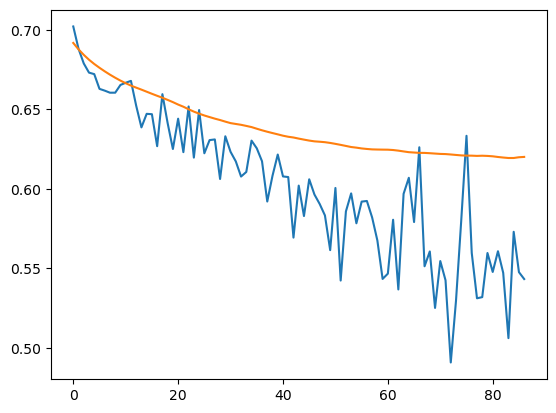

In [36]:
plt.plot(train_losses1)
plt.plot(val_losses1)

In [37]:
train_losses2, val_losses2 = train_baseline_model(model = nn_baseline2, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7424666285514832 |  Validation loss: 0.7198650240898132
Epoch 1: Training loss: 0.7159523367881775 |  Validation loss: 0.7187501788139343
Epoch 2: Training loss: 0.7204552292823792 |  Validation loss: 0.7177370190620422
Epoch 3: Training loss: 0.7398509979248047 |  Validation loss: 0.7167477607727051
Epoch 4: Training loss: 0.7211623191833496 |  Validation loss: 0.7157465815544128
Epoch 5: Training loss: 0.7186344265937805 |  Validation loss: 0.7148098349571228
Epoch 6: Training loss: 0.6959247589111328 |  Validation loss: 0.7139018177986145
Epoch 7: Training loss: 0.7129318118095398 |  Validation loss: 0.7130936980247498
Epoch 8: Training loss: 0.7184762954711914 |  Validation loss: 0.7123012542724609
Epoch 9: Training loss: 0.72287517786026 |  Validation loss: 0.7115075588226318
Epoch 10: Training loss: 0.7106999158859253 |  Validation loss: 0.7106968760490417
Epoch 11: Training loss: 0.7074519991874695 |  Validation loss: 0.7099261283874512
Epoch 12: Traini

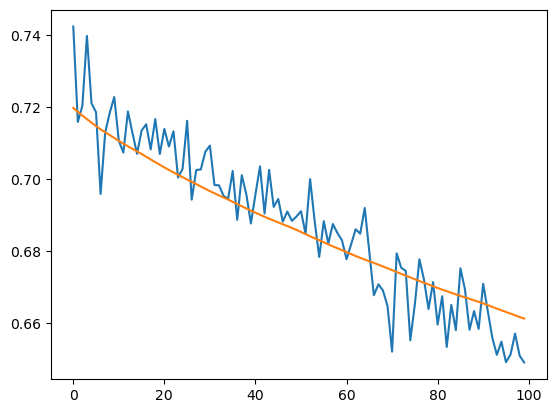

In [38]:
plt.plot(train_losses2)
plt.plot(val_losses2)

In [39]:
train_losses3, val_losses3 = train_baseline_model(model = nn_baseline3, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7199416160583496 |  Validation loss: 0.6991113424301147
Epoch 1: Training loss: 0.6946704983711243 |  Validation loss: 0.697421133518219
Epoch 2: Training loss: 0.6918551921844482 |  Validation loss: 0.6957685947418213
Epoch 3: Training loss: 0.679413378238678 |  Validation loss: 0.6941171288490295
Epoch 4: Training loss: 0.6809754967689514 |  Validation loss: 0.692560613155365
Epoch 5: Training loss: 0.6962548494338989 |  Validation loss: 0.6910077929496765
Epoch 6: Training loss: 0.6756312847137451 |  Validation loss: 0.6894934773445129
Epoch 7: Training loss: 0.678986668586731 |  Validation loss: 0.6880195140838623
Epoch 8: Training loss: 0.6933314800262451 |  Validation loss: 0.6865740418434143
Epoch 9: Training loss: 0.6693387627601624 |  Validation loss: 0.6851297616958618
Epoch 10: Training loss: 0.6705052256584167 |  Validation loss: 0.6837663054466248
Epoch 11: Training loss: 0.6575555205345154 |  Validation loss: 0.6824590563774109
Epoch 12: Training

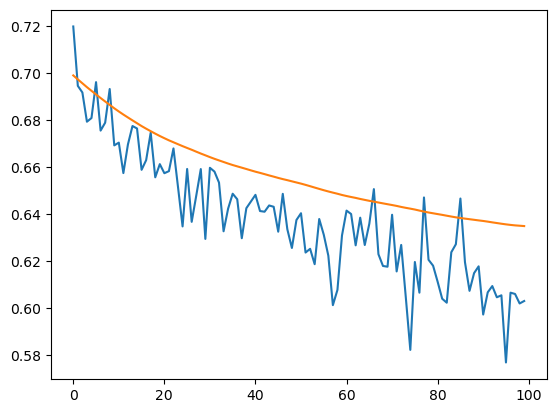

In [40]:
plt.plot(train_losses3)
plt.plot(val_losses3)

Running inference with each model

In [41]:
def inference_baseline_model(model):
    model.eval()
    y_test_pred = []
    test_y = []
    for idx, batch in enumerate(test_dataloader):
        y_test_pred.append(nn.Sigmoid()(model(batch[0].to(dtype=torch.float32))).detach())
        test_y.append(batch[1].detach())
    y_test_pred = torch.cat(y_test_pred)
    test_y = torch.cat(test_y)
    predictions = y_test_pred.detach().numpy().reshape(-1)
    auroc = roc_auc_score(test_y, predictions)
    auprc = average_precision_score(test_y, predictions)
    print(f"AUROC: {auroc}, AUPRC: {auprc}")

    # per drug inference
    res_df = pd.DataFrame(predictions, columns=["y_pred"])
    res_df["y_true"] = test_y
    res_df["drug"] = test_tcga_with_response.drug
    for d in res_df.drug.unique():
        try:
            subset_df = res_df[res_df.drug == d]
            auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
            auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
            print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
            print(subset_df.shape)
            print(subset_df.y_true.value_counts())
        except:
            continue

In [42]:
inference_baseline_model(nn_baseline1)

AUROC: 0.4421496311907271, AUPRC: 0.5968085140163031
Drug DOXORUBICIN | AUROC = 0.5277777777777778, AUPRC = 0.8044363044363045
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.33333333333333337, AUPRC = 0.3333333333333333
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.5151515151515151, AUPRC = 0.800977261654271
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.4428571428571429, AUPRC = 0.6919337525219877
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.17142857142857146, AUPRC = 0.3227272727272727
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.4575163398692811, AUPRC = 0.6097951432407815
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.36923076923076925, AUPRC = 0.7362103708257555
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.5, 

In [43]:
inference_baseline_model(nn_baseline2)

AUROC: 0.41591148577449955, AUPRC: 0.5841645892781719
Drug DOXORUBICIN | AUROC = 0.6388888888888888, AUPRC = 0.8676638176638178
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.33333333333333337, AUPRC = 0.3333333333333333
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.5176767676767676, AUPRC = 0.7946162668626136
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.4714285714285714, AUPRC = 0.6854523172905526
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.2571428571428571, AUPRC = 0.3477272727272727
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.5359477124183007, AUPRC = 0.6471280714469569
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.5076923076923077, AUPRC = 0.8001732053768251
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.5, 

In [44]:
inference_baseline_model(nn_baseline3)

AUROC: 0.4185458377239199, AUPRC: 0.5786847007871647
Drug DOXORUBICIN | AUROC = 0.5833333333333334, AUPRC = 0.8030303030303032
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.6666666666666667, AUPRC = 0.5
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.4747474747474747, AUPRC = 0.758206529338108
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.44285714285714284, AUPRC = 0.6376546982429334
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.17142857142857146, AUPRC = 0.32272727272727275
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.4117647058823529, AUPRC = 0.5942831334472201
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.41538461538461535, AUPRC = 0.7578472306979094
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.45833333333333337

#### Model with all cell lines + pseudo labels and train patient data -- FOCUS

In [45]:
cl_aug_train_dataset = CustomCellLineDataSet(sample_df=cl_responses_df)

In [46]:
len(cl_aug_train_dataset)

226796

In [47]:
cl_aug_train_dataloader = DataLoader(cl_aug_train_dataset, batch_size=128, shuffle=False)

In [48]:
def assign_pseudo_label(model):
    model.eval()
    cl_aug_train_y_pseudo = []
    for idx, batch in enumerate(cl_aug_train_dataloader):
        cl_aug_train_y_pseudo.append(nn.Sigmoid()(model(batch[0].to(dtype=torch.float32))).detach().cpu())
    cl_aug_train_y_pseudo = torch.cat(cl_aug_train_y_pseudo).numpy()
    return cl_aug_train_y_pseudo

In [49]:
baseline1_pseudolabels = assign_pseudo_label(nn_baseline1)

In [50]:
baseline1_pseudolabels.shape

(226796, 1)

In [51]:
baseline2_pseudolabels = assign_pseudo_label(nn_baseline2)
baseline2_pseudolabels.shape

(226796, 1)

In [52]:
baseline3_pseudolabels = assign_pseudo_label(nn_baseline3)
baseline3_pseudolabels.shape

(226796, 1)

In [53]:
pseudolabels_df = pd.concat([pd.Series(baseline1_pseudolabels.reshape(-1)), pd.Series(baseline2_pseudolabels.reshape(-1)), pd.Series(baseline3_pseudolabels.reshape(-1))], axis=1)
pseudolabels_df.columns = ["baseline1_preds", "baseline2_preds", "baseline3_preds"]
pseudolabels_df.describe()

,baseline1_preds,baseline2_preds,baseline3_preds
count,226796.000000,226796.000000,226796.000000
mean,0.569392,0.503774,0.553759
std,0.033832,0.021057,0.020463
min,0.453759,0.465710,0.490282
25%,0.552456,0.492339,0.543498
50%,0.565450,0.499327,0.551091
75%,0.578959,0.506931,0.560684
max,0.813683,0.634983,0.699954


In [54]:
baseline1_preds_25th = pseudolabels_df.describe()["baseline1_preds"]["25%"]
baseline1_preds_75th = pseudolabels_df.describe()["baseline1_preds"]["75%"]

baseline2_preds_25th = pseudolabels_df.describe()["baseline2_preds"]["25%"]
baseline2_preds_75th = pseudolabels_df.describe()["baseline2_preds"]["75%"]

baseline3_preds_25th = pseudolabels_df.describe()["baseline3_preds"]["25%"]
baseline3_preds_75th = pseudolabels_df.describe()["baseline3_preds"]["75%"]

In [55]:
def convert_binary(prediction, lower_threshold, upper_threshold):
    if prediction >= upper_threshold:
        return 1
    elif prediction < lower_threshold:
        return 0
    else:
        return -1

In [117]:
# convert to binary based on 25th and 75th percentile for each set of pseudo labels
pseudolabels_df["baseline1_preds_binary"] = pseudolabels_df["baseline1_preds"].apply(lambda x: convert_binary(x, 0.3, 0.7))
pseudolabels_df["baseline2_preds_binary"] = pseudolabels_df["baseline2_preds"].apply(lambda x: convert_binary(x, 0.4, 0.6))
pseudolabels_df["baseline3_preds_binary"] = pseudolabels_df["baseline3_preds"].apply(lambda x: convert_binary(x, 0.4, 0.6))

In [118]:
pseudolabels_df["baseline1_preds_binary"].value_counts()

baseline1_preds_binary
-1    222764
 1      4032
Name: count, dtype: int64

In [119]:
pseudolabels_df["baseline2_preds_binary"].value_counts()

baseline2_preds_binary
-1    226662
 1       134
Name: count, dtype: int64

In [120]:
pseudolabels_df["baseline3_preds_binary"].value_counts()

baseline3_preds_binary
-1    221949
 1      4847
Name: count, dtype: int64

In [121]:
def majority_vote(row):
    l1 = row["baseline1_preds_binary"]
    l2 = row["baseline2_preds_binary"]
    l3 = row["baseline3_preds_binary"]
    mod = mode([l1, l2, l3]).mode
    return mod
    
    

In [122]:
pseudolabels_df["majority_vote_pseudolabels"] = pseudolabels_df[["baseline1_preds_binary", "baseline2_preds_binary", "baseline3_preds_binary"]].apply(lambda x: majority_vote(x), axis =1)

In [123]:
pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels != -1]

,baseline1_preds,baseline2_preds,baseline3_preds,baseline1_preds_binary,baseline2_preds_binary,baseline3_preds_binary,majority_vote_pseudolabels
38573,0.722883,0.574102,0.619324,1,-1,1,1
38574,0.808203,0.594868,0.695688,1,-1,1,1
38575,0.807513,0.594725,0.697606,1,-1,1,1
38576,0.739657,0.612856,0.640615,1,1,1,1
38577,0.807375,0.594761,0.697297,1,-1,1,1
...,...,...,...,...,...,...,...
221084,0.771914,0.566592,0.648922,1,-1,1,1
221085,0.773571,0.566892,0.648267,1,-1,1,1
221086,0.773451,0.567683,0.650492,1,-1,1,1
221087,0.772022,0.566621,0.649011,1,-1,1,1


In [124]:
confident_cl_responses_df = cl_responses_df[cl_responses_df.index.isin(pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels != -1].index)].copy()
confident_cl_responses_df

,depmap_id,drug_name,auc
38573,ACH-000001,VINORELBINE,0.970728
38574,ACH-000002,VINORELBINE,0.906960
38575,ACH-000004,VINORELBINE,0.901564
38576,ACH-000006,VINORELBINE,0.889823
38577,ACH-000007,VINORELBINE,0.963060
...,...,...,...
221084,ACH-001654,EPIRUBICIN,0.859513
221085,ACH-001655,EPIRUBICIN,0.894020
221086,ACH-001674,EPIRUBICIN,0.956009
221087,ACH-001702,EPIRUBICIN,0.976968


In [125]:
confident_cl_responses_df["auc"] = pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels!= -1]["majority_vote_pseudolabels"]
confident_cl_responses_df

,depmap_id,drug_name,auc
38573,ACH-000001,VINORELBINE,1
38574,ACH-000002,VINORELBINE,1
38575,ACH-000004,VINORELBINE,1
38576,ACH-000006,VINORELBINE,1
38577,ACH-000007,VINORELBINE,1
...,...,...,...
221084,ACH-001654,EPIRUBICIN,1
221085,ACH-001655,EPIRUBICIN,1
221086,ACH-001674,EPIRUBICIN,1
221087,ACH-001702,EPIRUBICIN,1


In [126]:
confident_cl_responses_df.auc.value_counts()

auc
1    4065
Name: count, dtype: int64

In [127]:
cl_aug_pseudolabeled_dataset = CustomCellLineDataSet(confident_cl_responses_df)

In [128]:
cl_aug_pseudolabeled_dataloader = DataLoader(cl_aug_pseudolabeled_dataset, batch_size = 256, shuffle=True)

In [187]:
del nn_augmented_full
nn_augmented_full = BaseLineNN(9824, 1024).to(device)

In [188]:
optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-7)

In [189]:
# training 
train_losses = []
val_losses = []
count = 0
for i in range(100):
    for idx, batch in enumerate(cl_aug_pseudolabeled_dataloader):
        optim_aug.zero_grad()
        criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([[0.6]]*len(batch[0])).to(device))
        y_pred_aug = nn_augmented_full(batch[0].to(device, dtype=torch.float32))
        loss_aug = criterion_aug(y_pred_aug, batch[1].view(-1, 1).to(device, dtype=torch.float32))
        loss_aug.backward()
        optim_aug.step()
    for idx, batch in enumerate(train_dataloader): # the TCGA one
        optim_aug.zero_grad()
        criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([[0.6]]*len(batch[0])).to(device))
        y_pred_aug = nn_augmented_full(batch[0].to(device, dtype=torch.float32))
        loss_aug = criterion_aug(y_pred_aug, batch[1].view(-1, 1).to(device, dtype=torch.float32))
        loss_aug.backward()
        optim_aug.step()

    with torch.no_grad():
        val_loss = 0.0
        for idx, batch in enumerate(val_dataloader):
            criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([[0.6]]*len(batch[0])).to(device))
            val_loss += criterion_aug(nn_augmented_full(batch[0].to(device, dtype=torch.float32)), batch[1].view(-1, 1).to(device, dtype=torch.float32))
        val_loss /= (idx+1)

    print(f"Epoch {i}: Training loss: {loss_aug.detach().cpu().item()} |  Validation loss: {val_loss.detach().cpu().item()}")
    train_losses.append(loss_aug.detach().cpu().item())
    val_losses.append(val_loss.detach().cpu().item())

    if len(val_losses) > 2:
        if val_losses[-1]> val_losses[-2]:
            count +=1
    if count > 3:
        print("Converged")
        break

Epoch 0: Training loss: 0.5372574329376221 |  Validation loss: 0.5056400299072266
Epoch 1: Training loss: 0.48975062370300293 |  Validation loss: 0.5055884122848511
Epoch 2: Training loss: 0.5012297034263611 |  Validation loss: 0.5055357217788696
Epoch 3: Training loss: 0.4761160910129547 |  Validation loss: 0.5054829120635986
Epoch 4: Training loss: 0.538886547088623 |  Validation loss: 0.5054302215576172
Epoch 5: Training loss: 0.5394108891487122 |  Validation loss: 0.5053799152374268
Epoch 6: Training loss: 0.5004683136940002 |  Validation loss: 0.505329966545105
Epoch 7: Training loss: 0.541192889213562 |  Validation loss: 0.5052807331085205
Epoch 8: Training loss: 0.5034508109092712 |  Validation loss: 0.5052295327186584
Epoch 9: Training loss: 0.5137420892715454 |  Validation loss: 0.5051814913749695
Epoch 10: Training loss: 0.501830518245697 |  Validation loss: 0.5051331520080566
Epoch 11: Training loss: 0.5177776217460632 |  Validation loss: 0.5050832629203796
Epoch 12: Trainin

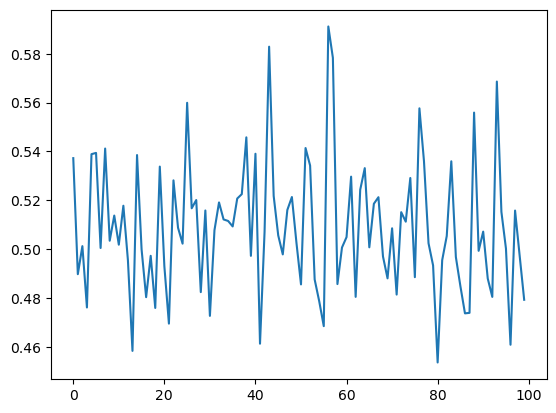

In [190]:
plt.plot(train_losses)

In [191]:
# inference
nn_augmented_full.eval()
y_test_pred = []
test_y = []
for idx, batch in enumerate(test_dataloader):
    y_test_pred.append(nn.Sigmoid()(nn_augmented_full(batch[0].to(device, dtype=torch.float32))).detach().cpu())
    test_y.append(batch[1].cpu())
y_test_pred = torch.cat(y_test_pred)
test_y = torch.cat(test_y)
y_test_pred.shape

torch.Size([203, 1])

In [192]:
predictions = y_test_pred.detach().cpu().numpy().reshape(-1)
predictions.shape

(203,)

In [193]:
auroc = roc_auc_score(test_y.numpy().reshape(-1), predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.4521601685985247, AUPRC: 0.6022061269471835


In [194]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = list(test_tcga_with_response["drug"])

In [195]:
res_df

,y_pred,y_true,drug
0,0.505444,0,METHOTREXATE
1,0.520907,0,DOXORUBICIN
2,0.528570,0,VINBLASTINE
3,0.497016,0,CISPLATIN
4,0.492119,0,GEMCITABINE
...,...,...,...
198,0.503050,1,CISPLATIN
199,0.533028,1,PACLITAXEL
200,0.497867,1,CISPLATIN
201,0.528914,1,PACLITAXEL


In [196]:
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug DOXORUBICIN | AUROC = 0.5277777777777778, AUPRC = 0.7859177859177859
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.33333333333333337, AUPRC = 0.3333333333333333
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.5909090909090909, AUPRC = 0.8433660015821579
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.6571428571428571, AUPRC = 0.7833225108225108
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.4285714285714286, AUPRC = 0.41757575757575754
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.5686274509803921, AUPRC = 0.6871254817095045
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.5230769230769231, AUPRC = 0.782662159358992
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.7083333333333334, AUPRC = 0.9501063751063753
(14, 3)
y_tr

In [197]:
# for DRP comparison
drugs_drp = ["DOXORUBICIN", "CISPLATIN", "PACLITAXEL", "GEMCITABINE", "5-FLUOROURACIL", "DOCETAXEL", "CYCLOPHOSPHAMIDE"]
subset_df2 = res_df[res_df.drug.isin(drugs_drp)]
print(subset_df2.shape)
auroc = roc_auc_score(subset_df2["y_true"], subset_df2["y_pred"])
auprc = average_precision_score(subset_df2["y_true"], subset_df2["y_pred"])
print(f"AUROC = {auroc}, AUPRC = {auprc}")

(147, 3)
AUROC = 0.4712418300653595, AUPRC = 0.6554361563785474


In [198]:
subset_df2[subset_df2.drug == "CYCLOPHOSPHAMIDE"]["y_true"].value_counts()

y_true
1    12
0     2
Name: count, dtype: int64

### Experimental Phase
Trying weak supervision - combine outputs from multiple label function using MajorityVoting to assign labels.

In [80]:
# # trying another 4 supervised classifiers trained on patient data and predicting on CL augmented
# from sklearn.ensemble import RandomForestClassifier
# rf1 = RandomForestClassifier(random_state=42, n_estimators=50)
# rf2 = RandomForestClassifier(random_state=1, max_depth=10)
# rf3 = RandomForestClassifier(random_state=0)
# # rf4 = RandomForestClassifier(random_state=3, n_estimators=10)

In [81]:
# rf3.fit(train_features, train_y)

In [82]:
# with open("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", "a") as f:
#     for idx, row in cl_responses_df.iterrows():
#         if row["drug_name"] in drug_fp.index:
#             row_inp = []
#             row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#             row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#             pred = rf3.predict(np.array(row_inp).reshape(1, -1))[0]
#             f.write(f"{pred}\n")
        

##### Combine weak labels from RF1, RF2, RF3 - Majority Voting

In [83]:
# rf1_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf1_augmented_cl_v2_pseudolabels.csv", header=None)
# rf2_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf2_augmented_cl_v2_pseudolabels.csv", header=None)
# rf3_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", header=None)

In [84]:
# import scipy.stats as st
# maj_labels = st.mode(np.concatenate((rf1_pred.values, rf2_pred.values, rf3_pred.values), axis = 1), axis = 1).mode

Train with these labels now

In [85]:
# cl_aug_train_features = []
# cl_aug_train_y = []
# for idx, row in cl_responses_df.iterrows():
#     if row["drug_name"] in drug_fp.index:
#         row_inp = []
#         row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#         row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#         cl_aug_train_y.append(maj_labels[idx])
#         cl_aug_train_features.append(row_inp)

In [86]:
# # Use pseudo labeled cell lines and patient train data to train
# cl_aug_features_tensor = torch.Tensor(cl_aug_train_features)

In [87]:
# X_train = torch.cat((train_features_tensor, cl_aug_features_tensor), dim=0)
# X_train

In [88]:
# y_train = torch.cat((train_y_tensor.view(-1, 1), torch.tensor(cl_aug_train_y).view(-1, 1)), dim = 0)

In [89]:
# del nn_augmented_full

In [90]:
# nn_augmented_full = BaseLineNN()

In [91]:
# criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3/4]*X_train.shape[0]))
# optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-4)

In [92]:
# # training 
# train_losses = []
# val_losses = []
# count = 0
# for i in range(500):
#     optim_aug.zero_grad()
#     y_pred_aug = nn_augmented_full(X_train.to(dtype=torch.float32))
#     loss_aug = criterion_aug(y_pred_aug, y_train.view(-1, 1).to(dtype=torch.float32))
#     loss_aug.backward()
#     optim_aug.step()

#     with torch.no_grad():
#         val_loss_aug = criterion_aug(nn_augmented_full(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

#     val_losses.append(val_loss_aug.detach().item())
#     print(f"Epoch {i}: Training loss: {loss_aug.detach().item()} |  Validation loss: {val_loss_aug.detach().item()}")
#     train_losses.append(loss_aug.detach().item())
#     if len(val_losses) > 2:
#         if val_losses[-1] > val_losses[-2]:
#             count += 1
#     if count > 3:
#         print("Converged")
#         break

In [93]:
# plt.plot(train_losses)

In [94]:
# # inference
# nn_augmented_full.eval()
# y_test_pred = nn.Sigmoid()(nn_augmented_full(test_features_tensor.to(dtype=torch.float32)))
# y_test_pred.shape

In [95]:
# predictions = y_test_pred.detach().numpy().reshape(-1)
# print(predictions.shape)
# auroc = roc_auc_score(test_y, predictions)
# auprc = average_precision_score(test_y, predictions)
# print(f"AUROC: {auroc}, AUPRC: {auprc}")

In [96]:
# # per drug
# res_df = pd.DataFrame(predictions, columns=["y_pred"])
# res_df["y_true"] = test_y
# res_df["drug"] = drugs

In [97]:
# for d in res_df.drug.unique():
#     try:
#         subset_df = res_df[res_df.drug == d]
#         auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
#         auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
#         print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
#         print(subset_df.shape)
#         print(subset_df.y_true.value_counts())
#     except:
#         continue